# Toy-Tokamak equilibirum



In [1]:
import numpy as np
from pyoculus.fields import AnalyticCylindricalBfield
from pyoculus.maps import CylindricalBfieldSection
from pyoculus.solvers import PoincarePlot, FixedPoint, Manifold

In [2]:
import logging
logging.basicConfig(level=logging.INFO)

Importing the field, the map used to compute the poincare plot, the solvers and setting the logging. Then setting the analytic field to be centered in $(R, Z) = (6, 0)$ with safety factor on axis $q_a = 0.91$ and shear $s = 0.6/2$.

In [3]:
separatrix = {"type": "circular-current-loop", "amplitude": -10, "R": 6, "Z": -5.5}
bfield = AnalyticCylindricalBfield(6, 0, 0.91, 0.6, perturbations_args=[separatrix])

The map that takes points in the $\phi_0$ plane and map them to the $\phi_0 + 2\pi/n_{fp}$ is instancized with tolerance of the integration set to $r_{tol} = 10^{-10}$. And as the added circular coil will shift the magnetic axis, we look for it by calling the classmethod `without_axis` :

In [4]:
section = CylindricalBfieldSection.without_axis(bfield, guess=[6.41, -0.7], rtol=1e-10)

INFO:pyoculus.solvers.fixed_point:Newton 0 - x : [ 6.41 -0.7 ]
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:pyoculus.solvers.fixed_point:Newton 0 - delta_x : [-0.0020629   0.01021609]
INFO:pyoculus.solvers.fixed_point:Newton 0 - step : [0.00409394 0.00631957]
INFO:pyoculus.solvers.fixed_point:Newton 1 - x : [ 6.41409394 -0.69368043]
INFO:pyoculus.solvers.fixed_point:Newton 1 - delta_x : [1.38201281e-06 6.13941403e-06]
INFO:pyoculus.solvers.fixed_point:Newton 1 - step : [3.86793226e-06 1.79737352e-06]
INFO:pyoculus.solvers.fixed_point:Newton 2 - x : [ 6.41409781 -0.69367863]
INFO:pyoculus.solvers.fixed_point:Newton 2 - delta_x : [7.43227702e-12 6.34925446e-12]
INFO:pyoculus.solvers.fixed_point:Found fixed point at [ 6.41409781 -0.69367

### Plotting the unperturbed equilibrium 

The poincare section at this point can be plotted. Two initial segments are of interest : the first joining the magnetic axis to the X-point of the single null equilibrium and the second joining the X-point to the position of the circular coil. We must then, before initializing a PoincarePlot object, find the X-point :

In [5]:
fp_x = FixedPoint(section)
guess = [6.21560891, -4.46981856]
fp_x.find(1, guess)

INFO:pyoculus.solvers.fixed_point:Newton 0 - x : [ 6.21560891 -4.46981856]
INFO:pyoculus.solvers.fixed_point:Newton 0 - delta_x : [0.36812511 0.29366272]
INFO:pyoculus.solvers.fixed_point:Newton 0 - step : [-0.0236111  -0.02026723]
INFO:pyoculus.solvers.fixed_point:Newton 1 - x : [ 6.19199781 -4.49008579]
INFO:pyoculus.solvers.fixed_point:Newton 1 - delta_x : [-0.161072  -0.1732541]
INFO:pyoculus.solvers.fixed_point:Newton 1 - step : [0.00559025 0.00256556]
INFO:pyoculus.solvers.fixed_point:Newton 2 - x : [ 6.19758806 -4.48752024]
INFO:pyoculus.solvers.fixed_point:Newton 2 - delta_x : [-0.01704153 -0.02901229]
INFO:pyoculus.solvers.fixed_point:Newton 2 - step : [ 0.00597728 -0.00824633]
INFO:pyoculus.solvers.fixed_point:Newton 3 - x : [ 6.20356534 -4.49576657]
INFO:pyoculus.solvers.fixed_point:Newton 3 - delta_x : [0.00039688 0.00018237]
INFO:pyoculus.solvers.fixed_point:Newton 3 - step : [ 5.74398544e-05 -1.32091786e-04]
INFO:pyoculus.solvers.fixed_point:Newton 4 - x : [ 6.20362278 -4

We can now set the coordinates of the points. Note that evolving the magnetic axis is not giving us more information and at the coil position the magnetic field will be infinit, thus leading to integration error. We resolve this problem by starting/ending with a little $\varepsilon$. 

In [6]:
xpoint = fp_x.coords[0]
opoint = np.array([section.R0, section.Z0])
coilpoint = np.array(
    [bfield.perturbations_args[0]["R"], bfield.perturbations_args[0]["Z"]]
)

In [7]:
A = opoint + 1e-4 * (xpoint - opoint) / np.linalg.norm(xpoint - opoint)
C = coilpoint - 1e-1 * (coilpoint - xpoint) / np.linalg.norm(coilpoint - xpoint)

And finally instancized the PoincarePlot :

In [8]:
pplot = PoincarePlot.with_segments(section, [A, xpoint, C], [20, 5])

The `PoincarePlot` can be computed, here with 1 process and also recording the winding number at the same time for future plot of its profile.

In [9]:
pplot.compute(nprocess=1, compute_iota=True)

array([[[ 6.41409228, -0.69377848],
        [ 6.41401656, -0.69368808],
        [ 6.41406821, -0.69358287],
        ...,
        [ 6.41416215, -0.69362059],
        [ 6.41416164, -0.69374633],
        [ 6.41406108, -0.69376595]],

       [[ 6.40301494, -0.89389007],
        [ 6.25212652, -0.71468641],
        [ 6.38782343, -0.49460494],
        ...,
        [ 6.5275747 , -0.84604994],
        [ 6.33601374, -0.86499321],
        [ 6.2590681 , -0.61533811]],

       [[ 6.3919376 , -1.09400166],
        [ 6.086958  , -0.68473711],
        [ 6.54665382, -0.33953036],
        ...,
        [ 6.29121424, -1.05714859],
        [ 6.11335399, -0.51085709],
        [ 6.66573982, -0.45494784]],

       ...,

       [[ 6.11174868, -4.94894678],
        [ 6.12517411, -4.9511325 ],
        [ 6.13844862, -4.95419216],
        ...,
        [ 6.32043783, -5.13110645],
        [ 6.33021894, -5.15545833],
        [ 6.33921835, -5.18239088]],

       [[ 6.06581162, -5.17547084],
        [ 5.78763926, -5.46

And we get the plot ! We can even add the three indicative points to the plot.

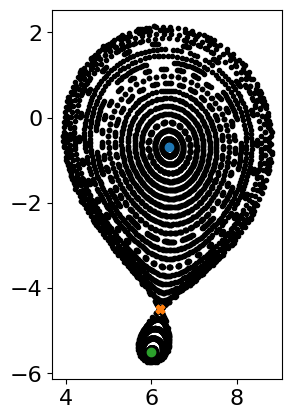

In [10]:
fig, ax = pplot.plot()
ax.scatter(*opoint)
fp_x.plot(ax=ax)
ax.scatter(*coilpoint)

Now let's get the iota profile for 

In [11]:
pplot.compute_iota()

(array([[ 6.41409228, -0.69377848],
        [ 6.40301494, -0.89389007],
        [ 6.3919376 , -1.09400166],
        [ 6.38086026, -1.29411325],
        [ 6.36978292, -1.49422483],
        [ 6.35870558, -1.69433642],
        [ 6.34762823, -1.89444801],
        [ 6.33655089, -2.0945596 ],
        [ 6.32547355, -2.29467119],
        [ 6.31439621, -2.49478278],
        [ 6.30331887, -2.69489437],
        [ 6.29224153, -2.89500596],
        [ 6.28116418, -3.09511755],
        [ 6.27008684, -3.29522914],
        [ 6.2590095 , -3.49534073],
        [ 6.24793216, -3.69545232],
        [ 6.23685482, -3.89556391],
        [ 6.22577748, -4.0956755 ],
        [ 6.21470013, -4.29578709],
        [ 6.20362279, -4.49589868],
        [ 6.15768573, -4.72242273],
        [ 6.11174868, -4.94894678],
        [ 6.06581162, -5.17547084],
        [ 6.01987456, -5.40199489]]),
 array([ 7.92515533e-01,  7.81128288e-01,  7.49366571e-01,  7.02466429e-01,
         6.46693828e-01,  5.87723726e-01,  5.29787668e-01,

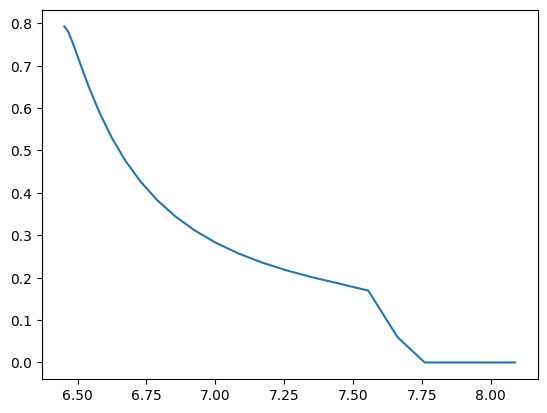

In [12]:
import matplotlib.pyplot as plt
plt.plot(np.linalg.norm(pplot.xs, axis=1), pplot.iota)

## Adding the maxwellian perturbation

In [13]:
maxwellboltzmann = {"R": section.R0, "Z": section.Z0, "m": 6, "n": -1, "d": np.sqrt(2), "type": "maxwell-boltzmann", "amplitude": 1e-1}
bfield.add_perturbation(maxwellboltzmann)

section.clear_cache()
section.find_axis()

INFO:pyoculus.solvers.fixed_point:Newton 0 - x : [ 6.41409781 -0.69367863]
INFO:pyoculus.solvers.fixed_point:Newton 0 - delta_x : [7.43138884e-12 6.34847730e-12]
INFO:pyoculus.solvers.fixed_point:Found fixed point at [ 6.41409781 -0.69367863]. Computing additional data...


In [14]:
fp_x = FixedPoint(section)
guess = [6.21560891, -4.46981856]

fp_x.find(1, guess)
# fp01.find_with_iota(0, 1, guess)

fp_x._found_by_iota = True
fp_x._m = 1

INFO:pyoculus.solvers.fixed_point:Newton 0 - x : [ 6.21560891 -4.46981856]
INFO:pyoculus.solvers.fixed_point:Newton 0 - delta_x : [0.37061925 0.29572031]
INFO:pyoculus.solvers.fixed_point:Newton 0 - step : [-0.0234823  -0.02119928]
INFO:pyoculus.solvers.fixed_point:Newton 1 - x : [ 6.19212661 -4.49101784]
INFO:pyoculus.solvers.fixed_point:Newton 1 - delta_x : [-0.1651057  -0.17691821]
INFO:pyoculus.solvers.fixed_point:Newton 1 - step : [0.00515258 0.00348819]
INFO:pyoculus.solvers.fixed_point:Newton 2 - x : [ 6.19727919 -4.48752965]
INFO:pyoculus.solvers.fixed_point:Newton 2 - delta_x : [-0.01794846 -0.03057362]
INFO:pyoculus.solvers.fixed_point:Newton 2 - step : [ 0.00628992 -0.00868501]
INFO:pyoculus.solvers.fixed_point:Newton 3 - x : [ 6.20356912 -4.49621466]
INFO:pyoculus.solvers.fixed_point:Newton 3 - delta_x : [0.00043682 0.00019993]
INFO:pyoculus.solvers.fixed_point:Newton 3 - step : [ 6.34979261e-05 -1.46029594e-04]
INFO:pyoculus.solvers.fixed_point:Newton 4 - x : [ 6.20363261 

In [15]:
xpoint = fp_x.coords[0]
opoint = np.array([section.R0, section.Z0])
coilpoint = np.array(
    [bfield.perturbations_args[0]["R"], bfield.perturbations_args[0]["Z"]]
)
A = opoint + 1e-4 * (xpoint - opoint) / np.linalg.norm(xpoint - opoint)
C = coilpoint - 1e-1 * (coilpoint - xpoint) / np.linalg.norm(coilpoint - xpoint)
pplot = PoincarePlot.with_segments(section, [A, xpoint, C], [20, 5])
pplot.compute(nprocess=1, compute_iota=False)

array([[[ 6.41409229, -0.69377848],
        [ 6.41401885, -0.69368774],
        [ 6.41406986, -0.69358457],
        ...,
        [ 6.41417208, -0.69364255],
        [ 6.41414507, -0.69375953],
        [ 6.41404559, -0.69374859]],

       [[ 6.40301546, -0.89391438],
        [ 6.25663765, -0.71376427],
        [ 6.38887534, -0.49535812],
        ...,
        [ 6.55154503, -0.80740504],
        [ 6.3744699 , -0.88370849],
        [ 6.2545397 , -0.67071368]],

       [[ 6.39193864, -1.09405029],
        [ 6.09729502, -0.68463858],
        [ 6.53615572, -0.34395584],
        ...,
        [ 6.6708726 , -0.94246657],
        [ 6.30248094, -1.05358773],
        [ 6.11077813, -0.523872  ]],

       ...,

       [[ 6.11175845, -4.94917879],
        [ 6.1209074 , -4.95056954],
        [ 6.12998482, -4.95236426],
        ...,
        [ 6.29000723, -5.0742983 ],
        [ 6.29762151, -5.08670987],
        [ 6.30507433, -5.09996358]],

       [[ 6.06582136, -5.17558782],
        [ 5.79007571, -5.48

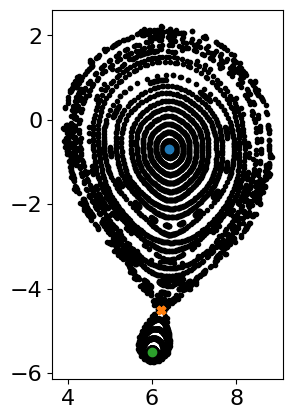

In [16]:
fig, ax = pplot.plot()
ax.scatter(*opoint)
fp_x.plot(ax=ax)
ax.scatter(*coilpoint)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

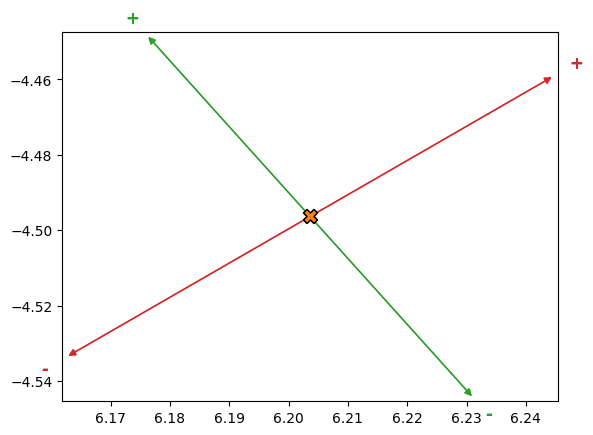

In [17]:
Manifold.show_directions(fp_x, fp_x)

In [18]:
manif = Manifold(section, fp_x, fp_x, '+', '+', is_first_stable=True)

In [ ]:
manif.compute(eps_s=1e-6, eps_u=1e-6, nint_s=9, nint_u=9)
manif.plot(ax=ax, rm_points=10)

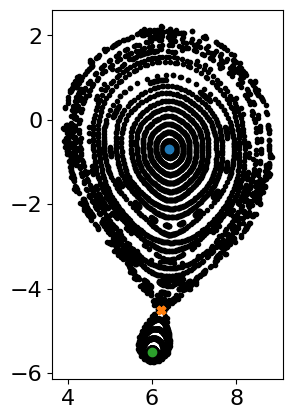

In [20]:
fig

In [ ]:
manif.find_clinics()

In [ ]:
# Finding the clinics
i, s_shift = 6, 2
n_s, n_u = i+s_shift, i-s_shift
manif.onworking = manif.inner
# Find the first clinic
eps_s_i, eps_u_i = 2e-5, 2e-5

manif.find_clinic_single(eps_s_i, eps_u_i, n_s=n_s, n_u=n_u)
manif.find_clinics(n_points=2)
manif.plot_clinics(ax=ax)

In [ ]:
fig

In [ ]:
manif.turnstile_area()